In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Import Dataset

In [2]:
with open('MyFinalDic.pkl', 'rb') as f:
    final_dic = pickle.load(f)

## Preprocessing Outout

In [3]:
# Step 1: Extract ATECO and COD_STAT from Final_dic
ateco_list = final_dic.get('ATECO', [])
cod_stat_list = final_dic.get('COD STAT', [])

# Step 2: Filter keys that start with "BSBT"
filtered_dic = {k: v for k, v in final_dic.items() if k.startswith('BSBT')}
#print(len(filtered_dic))
# Step 3: Create a list of column names and their corresponding values (lists)
column_names = []
data = {}

for key in filtered_dic:
    # Extract the number after BSBT (e.g., for BSBT1 -> 1)
    index = int(key.replace('BSBT', '')) - 1  # Subtract 1 because lists are zero-indexed

    # Get the corresponding values from ATECO and COD_STAT
    ateco_value = ateco_list[index] if index < len(ateco_list) else 'NA'
    cod_stat_value = cod_stat_list[index] if index < len(cod_stat_list) else 'NA'

    # Create the new column name in the format {index+1}_{ATECO_value}_{COD_STAT_value}
    column_name = f"{index+1}_{ateco_value}_{cod_stat_value}"

    # Add the column name and the corresponding list of values to the dictionary
    column_names.append(column_name)
    data[column_name] = filtered_dic[key]  # Assuming each value is a list

# Step 4: Create the DataFrame with the column names as headers and lists as columns
y = pd.DataFrame(data)
print(y)

      8_85_801  23_46_248  37_47_521  38_64_650  39_70_9  42_47_521  46_47_9  \
0        8.110      17.32      44.72      47.52   43.075     16.050    38.48   
1        8.170      19.01      47.84      48.22   30.125     16.500    38.68   
2        8.110      17.25      45.68      48.10   18.350     17.050    38.42   
3        8.180      17.32      46.44      48.12   15.900     19.250    39.84   
4        8.190      17.30      44.56      47.96   12.850     16.175    41.32   
...        ...        ...        ...        ...      ...        ...      ...   
8755    17.861      10.78      43.84      25.14   42.125     28.400    45.46   
8756    18.614      11.68      48.60      18.22   40.975     16.300    44.18   
8757    18.997      10.30      45.44      18.26   47.075     17.400    44.54   
8758    16.553      10.71      42.20      18.40   49.425     16.150    40.56   
8759    10.355      10.09      43.28      17.62   50.325     17.150    37.90   

      56_47_930  61_47_9  62_70_9  ... 

## Preprocessing the input

In [4]:
# Create UTC values for 8760 samples
start_date = pd.to_datetime('2019-01-01 00:00:00')
end_date = pd.to_datetime('2019-12-31 23:00:00')  # 8760 hourly samples
utc_values = pd.date_range(start=start_date, end=end_date, freq='h')

# Ensure 'UTC' column is inserted into LoadBSBT
if 'UTC' not in y.columns:
    y.insert(0, 'UTC', utc_values)
else:
    print("UTC column already exists, skipping insertion.")

# Ensure the 'UTC' column is in datetime format
y['UTC'] = pd.to_datetime(y['UTC'])

# Step 1: Insert the UTC column and set as index
y.set_index('UTC', inplace=True)

# Step 2: Define the get_tariff function
def get_tariff(row):
    day_of_week = row.name.dayofweek
    hour = row.name.hour

    if (day_of_week >= 0) and (day_of_week <= 4) and (hour >= 8) and (hour <= 18):
        return 'F1'
    elif ((day_of_week >= 0) and (day_of_week <= 4) and ((hour == 7) or (hour >= 19 and hour <= 22))) or ((day_of_week == 5) and (hour >= 7 and hour <= 22)):
        return 'F2'
    else:
        return 'F3'

# Apply the tariff function to each row to create a 'Tariff' column
y['Tariff'] = y.apply(get_tariff, axis=1)

# Step 3: Calculate monthly tariff-based energy for each load
# Initialize the list to hold energy values for each load
energy_data = []

# Iterate over each load column (excluding 'Tariff' column)
for load_name in y.columns[:-1]:
    load_id_parts = load_name.split('_')
    Load_Name = load_id_parts[0]
    ATECO = load_id_parts[1]
    STATISTICO = load_id_parts[2]

    if ATECO == 'Sconosciuto' or STATISTICO == 'Sconosciuto':
        ATECO = 0
        STATISTICO = 0
        print("yes")

    # Group by month and tariff, summing the energy per tariff per month
    monthly_tariff_energy = y.groupby([y.index.month, 'Tariff'])[load_name].sum().unstack(fill_value=0)

    # Make sure all tariffs (F1, F2, F3) exist for every month; if missing, fill with 0
    monthly_tariff_energy = monthly_tariff_energy.reindex(columns=['F1', 'F2', 'F3'], fill_value=0)

    # Flatten the monthly tariff data into a single list (F1_1, F2_1, F3_1, ..., F1_12, F2_12, F3_12)
    flattened_energy = monthly_tariff_energy.values.flatten()

    # Append the energy values, Load Name, ATECO, and STATISTICO for this load
    energy_data.append([Load_Name] + list(flattened_energy) + [ATECO, STATISTICO])

# Step 4: Create a new DataFrame with 38 columns (Load_Name, tariff data, ATECO, STATISTICO)
energy_df = pd.DataFrame(energy_data, columns=['Load_Name'] +
                                              [f'F{tariff}_{month}' for month in range(1, 13) for tariff in range(1, 4)] + ['ATECO', 'STATISTICO'])

# Calculate total F1, F2, F3 for each load
energy_df['F1'] = energy_df[[f'F1_{month}' for month in range(1, 13)]].sum(axis=1)
energy_df['F2'] = energy_df[[f'F2_{month}' for month in range(1, 13)]].sum(axis=1)
energy_df['F3'] = energy_df[[f'F3_{month}' for month in range(1, 13)]].sum(axis=1)

# Calculate total energy Et
energy_df['Et'] = energy_df['F1'] + energy_df['F2'] + energy_df['F3']

# Calculate ratios
energy_df['F1_F2'] = energy_df['F1'] / energy_df['F2'].replace(0, np.nan)  # Avoid division by zero
energy_df['F1_F3'] = energy_df['F1'] / energy_df['F3'].replace(0, np.nan)
energy_df['F1_Et'] = energy_df['F1'] / energy_df['Et'].replace(0, np.nan)
energy_df['F2_Et'] = energy_df['F2'] / energy_df['Et'].replace(0, np.nan)
energy_df['F3_Et'] = energy_df['F3'] / energy_df['Et'].replace(0, np.nan)

# Drop the 'Load_Name' column if needed
energy_df.drop(columns=['Load_Name'], inplace=True, errors='ignore')


# Final energy DataFrame with the load name, energy per tariff, ATECO, and STATISTICO
y.drop(columns=['Tariff'], inplace=True, errors='ignore')
yT = y.T
print(yT.shape)

X = energy_df
print(X.shape)


(925, 8760)
(925, 47)


In [43]:
print(X)

             F1_1       F2_1          F3_1          F1_2          F2_2  \
0    10429.580000   4559.270   3200.880000   9366.580000   4103.850000   
1     9996.440000   5275.600   5859.570000   8314.320000   4557.370000   
2    28551.240000  14371.880  17620.880000  23112.880000  12999.760000   
3    12621.560000   4151.140   6964.900000  11803.795000   4029.923000   
4     6901.750000   5840.000   6610.975000   5862.775000   5034.925000   
..            ...        ...           ...           ...           ...   
920   4093.600000   1984.300   2822.175000   3769.030000   2049.998000   
921   4607.975000   5867.775  13180.071038   2378.596284   2612.116831   
922   3301.092004    764.163    801.246000   3247.792497    729.958241   
923   3319.620268   1985.436   1511.160000   3221.000000   1805.525000   
924   1598.625000    654.750    630.714637   2045.400000   1094.475000   

            F3_2          F1_3          F2_3          F3_3       F1_4  ...  \
0     2857.00000   9376.690000   

# Neural Network

## Multi-Layer Perceptron (MLP)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

class MLPEnergyPredictor(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=[512, 1024, 1024]):
        super(MLPEnergyPredictor, self).__init__()

        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(0.2))
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Feature scaling
le_ateco = LabelEncoder()
le_statistico = LabelEncoder()

X['ATECO'] = le_ateco.fit_transform(X['ATECO'].astype(str))
X['STATISTICO'] = le_statistico.fit_transform(X['STATISTICO'].astype(str))

scaler_X = RobustScaler()
scaler_y = RobustScaler()

y_scaled = torch.tensor(scaler_y.fit_transform(yT), dtype=torch.float32)
X_scaled = torch.tensor(scaler_X.fit_transform(X), dtype=torch.float32)

print("Input shape:", X_scaled.shape)
print("Output shape:", y_scaled.shape)

# Split the data into train and validation sets
train_size = int(0.8 * len(X_scaled))
val_size = len(X_scaled) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X_scaled, y_scaled), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize the model
model = MLPEnergyPredictor(input_size=X_scaled.shape[1], output_size=y_scaled.shape[1])

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Training loop
num_epochs = 500
best_val_loss = float('inf')
patience = 20
no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            val_loss += criterion(outputs, batch_y).item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    # Step the scheduler
    scheduler.step(val_loss)
    # print(f'Current learning rate: {scheduler.get_last_lr()}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Make predictions on the entire dataset
with torch.no_grad():
    predictions_scaled = model(X_scaled)  # Get predictions from the model

# Convert predictions from a PyTorch tensor to a NumPy array for inverse scaling
predictions_scaled = predictions_scaled.numpy()  

# Inverse transform the predictions and true values
predictions = scaler_y.inverse_transform(predictions_scaled)

# Convert y_true to a NumPy array
y_true = yT.values

# Calculate evaluation metrics
mse = mean_squared_error(y_true, predictions)
mae = mean_absolute_error(y_true, predictions)
r2 = r2_score(y_true, predictions)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

Input shape: torch.Size([925, 47])
Output shape: torch.Size([925, 8760])


C:\Users\morte\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [10/500], Train Loss: 0.2957, Val Loss: 0.1866
Epoch [20/500], Train Loss: 0.2882, Val Loss: 0.2556
Epoch [30/500], Train Loss: 0.2283, Val Loss: 0.1720
Epoch [40/500], Train Loss: 0.2078, Val Loss: 0.1897
Epoch [50/500], Train Loss: 0.2033, Val Loss: 0.1651
Epoch [60/500], Train Loss: 0.1766, Val Loss: 0.1430
Epoch [70/500], Train Loss: 0.1695, Val Loss: 0.1406
Epoch [80/500], Train Loss: 0.1620, Val Loss: 0.1491
Epoch [90/500], Train Loss: 0.1574, Val Loss: 0.1387
Early stopping triggered at epoch 92
Mean Squared Error: 44.7171
Mean Absolute Error: 4.1762
R2 Score: 0.8946


### Visualization

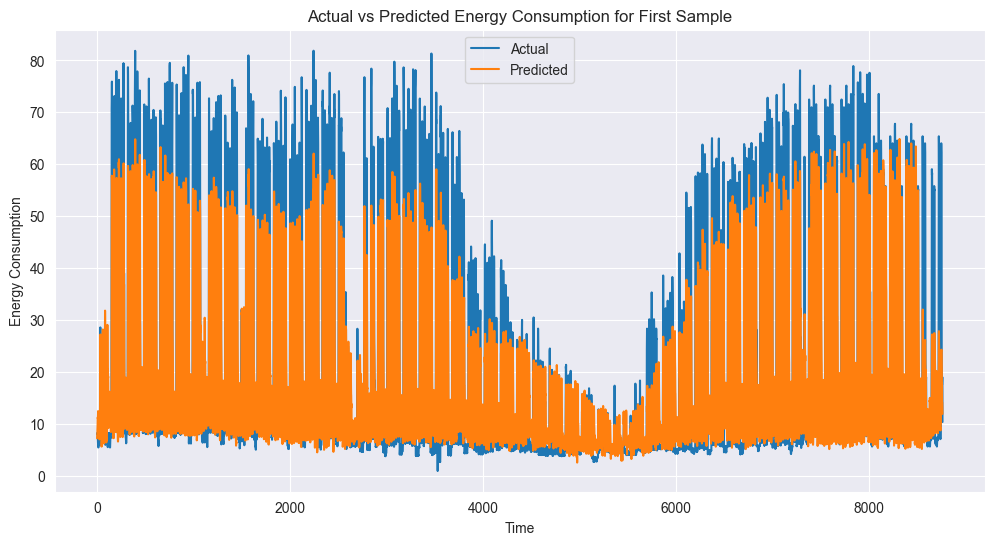

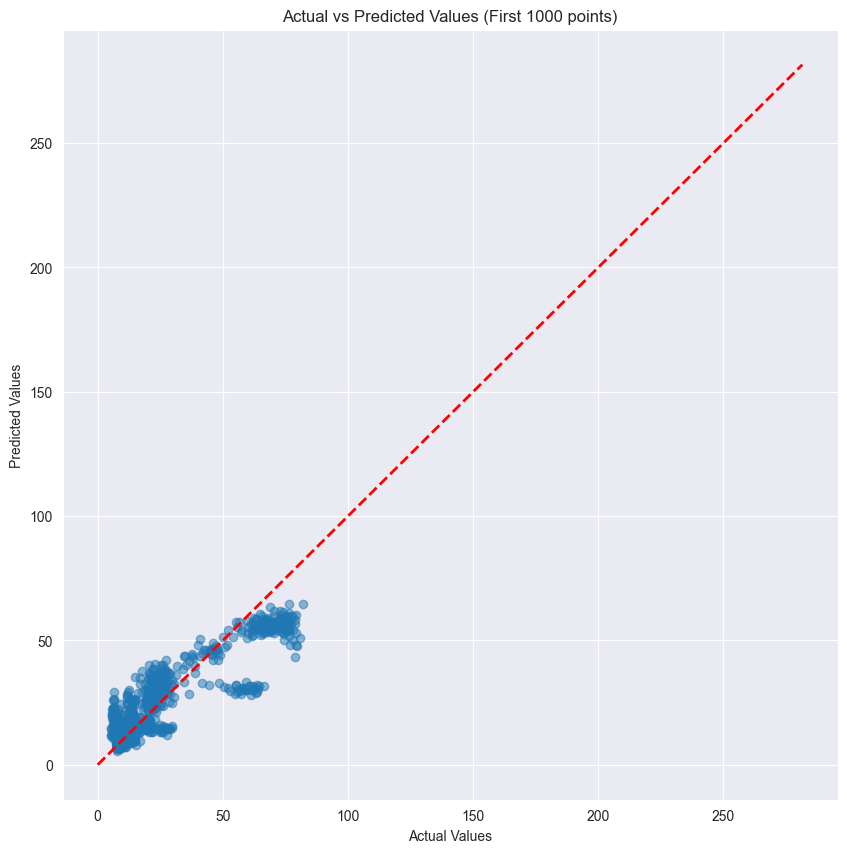

In [8]:
# Plot the first prediction and real curve
plt.figure(figsize=(12, 6))
plt.plot(y_true[0], label='Actual')
plt.plot(predictions[0], label='Predicted')
plt.title('Actual vs Predicted Energy Consumption for First Sample')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

# Plot a scatter plot of actual vs predicted values for the first 1000 points
plt.figure(figsize=(10, 10))
plt.scatter(y_true.flatten()[:1000], predictions.flatten()[:1000], alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (First 1000 points)')
plt.show()

Input shape: torch.Size([925, 47])
Output shape: torch.Size([925, 8760])

Fold 1


C:\Users\morte\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [10/500], Train Loss: 0.4408, Val Loss: 0.2617
Epoch [20/500], Train Loss: 0.3178, Val Loss: 0.2152
Epoch [30/500], Train Loss: 0.2674, Val Loss: 0.2370
Early stopping triggered at epoch 33

Evaluation for Fold 1:
Mean Squared Error: 85.4619
Mean Absolute Error: 5.8956
R2 Score: 0.8031

Feature Importance:
    feature  importance       std
22       22    0.072308  0.002651
21       21    0.037769  0.001021
35       35    0.034172  0.001306
2         2    0.025778  0.000902
29       29    0.023735  0.001336
20       20    0.023384  0.001401
26       26    0.018778  0.000935
23       23    0.017954  0.000645
19       19    0.016701  0.000868
13       13    0.016388  0.000493
8         8    0.016219  0.000691
14       14    0.014957  0.000832
18       18    0.014279  0.000717
17       17    0.013462  0.000539
32       32    0.012714  0.000538
11       11    0.011942  0.000429
40       40    0.010927  0.000452
34       34    0.010605  0.000327
1         1    0.010364  0.000533
5     

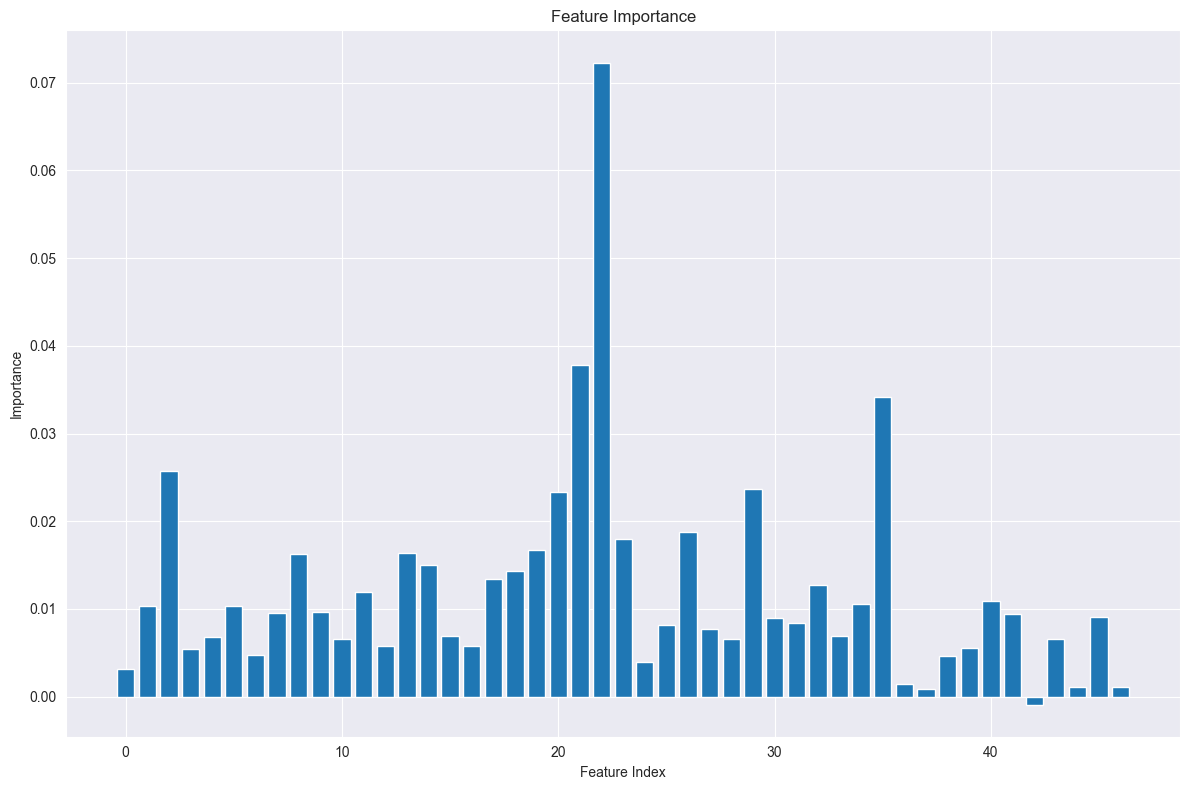


Fold 2


C:\Users\morte\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [10/500], Train Loss: 0.4481, Val Loss: 0.3035
Epoch [20/500], Train Loss: 0.4267, Val Loss: 0.2187
Epoch [30/500], Train Loss: 0.2777, Val Loss: 0.2213
Epoch [40/500], Train Loss: 0.2216, Val Loss: 0.2498
Early stopping triggered at epoch 41

Evaluation for Fold 2:
Mean Squared Error: 98.7047
Mean Absolute Error: 6.3628
R2 Score: 0.7795

Fold 3


C:\Users\morte\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [10/500], Train Loss: 0.5287, Val Loss: 0.2235
Epoch [20/500], Train Loss: 0.3292, Val Loss: 0.1812
Epoch [30/500], Train Loss: 0.2949, Val Loss: 0.1769
Epoch [40/500], Train Loss: 0.2377, Val Loss: 0.1890
Epoch [50/500], Train Loss: 0.2358, Val Loss: 0.1516
Early stopping triggered at epoch 52

Evaluation for Fold 3:
Mean Squared Error: 70.0503
Mean Absolute Error: 5.3937
R2 Score: 0.7966

Fold 4


C:\Users\morte\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [10/500], Train Loss: 0.4842, Val Loss: 0.4565
Epoch [20/500], Train Loss: 0.3454, Val Loss: 0.2175
Early stopping triggered at epoch 28

Evaluation for Fold 4:
Mean Squared Error: 87.3599
Mean Absolute Error: 6.1399
R2 Score: 0.7875

Fold 5


C:\Users\morte\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [10/500], Train Loss: 0.5214, Val Loss: 0.2688
Epoch [20/500], Train Loss: 0.3202, Val Loss: 0.2920
Epoch [30/500], Train Loss: 0.2671, Val Loss: 0.2392
Epoch [40/500], Train Loss: 0.2417, Val Loss: 0.2267
Early stopping triggered at epoch 43

Evaluation for Fold 5:
Mean Squared Error: 81.8264
Mean Absolute Error: 5.7092
R2 Score: 0.8118


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, RegressorMixin

# Define the MLP model with residual connections
class MLPEnergyPredictor(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=[512, 1024, 1024]):
        super(MLPEnergyPredictor, self).__init__()

        layers = []
        prev_size = input_size
        for i, hidden_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.LeakyReLU())
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(0.2))
            if i > 0 and i % 2 == 0:  # Add residual connections every 2 layers
                layers.append(ResidualConnection(hidden_size))
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class ResidualConnection(nn.Module):
    def __init__(self, size):
        super(ResidualConnection, self).__init__()
        self.size = size

    def forward(self, x):
        return x + x  # Identity connection (this can be customized)

# Preprocessing function for feature scaling
def preprocess_data(X, y):
    le_ateco = LabelEncoder()
    le_statistico = LabelEncoder()

    X['ATECO'] = le_ateco.fit_transform(X['ATECO'].astype(str))
    X['STATISTICO'] = le_statistico.fit_transform(X['STATISTICO'].astype(str))

    scaler_X = RobustScaler()
    scaler_y = RobustScaler()

    X_scaled = torch.tensor(scaler_X.fit_transform(X), dtype=torch.float32)
    y_scaled = torch.tensor(scaler_y.fit_transform(yT), dtype=torch.float32)

    return X_scaled, y_scaled, scaler_X, scaler_y

# Training function for the model
def train_model(model, train_loader, val_loader, num_epochs=500, patience=10):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

    best_val_loss = float('inf')
    no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                val_loss += criterion(outputs, batch_y).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        scheduler.step(val_loss)  # Step the scheduler with validation loss

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    model.load_state_dict(torch.load('best_model.pth'))
    return model

# Evaluation function for the model
def evaluate_model(model, X, y, scaler_y):
    model.eval()
    with torch.no_grad():
        predictions_scaled = model(X)

    predictions = scaler_y.inverse_transform(predictions_scaled.numpy())
    y_true = scaler_y.inverse_transform(y.numpy())

    mse = mean_squared_error(y_true, predictions)
    mae = mean_absolute_error(y_true, predictions)
    r2 = r2_score(y_true, predictions)

    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R2 Score: {r2:.4f}")

# Wrapper class for the model to use in permutation importance
class TorchModelWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        return self

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        self.model.eval()
        with torch.no_grad():
            return self.model(X_tensor).numpy()

# Function to evaluate feature importance using permutation importance
def evaluate_feature_importance(model, X, y, n_repeats=10):
    model.eval()
    X_np = X.numpy()
    y_np = y.numpy()

    wrapped_model = TorchModelWrapper(model)

    r = permutation_importance(wrapped_model, X_np, y_np, n_repeats=n_repeats, random_state=42)

    feature_importance = pd.DataFrame({
        'feature': range(X.shape[1]),
        'importance': r.importances_mean,
        'std': r.importances_std
    }).sort_values('importance', ascending=False)

    return feature_importance

# Function to plot the feature importance
def plot_feature_importance(feature_importance):
    plt.figure(figsize=(12, 8))
    plt.bar(feature_importance['feature'], feature_importance['importance'])
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

# Main function to execute the pipeline
def main():
    # Load data here (X, y)
    # For example: X, y = load_your_data()

    X_scaled, y_scaled, scaler_X, scaler_y = preprocess_data(X, y)

    print("Input shape:", X_scaled.shape)
    print("Output shape:", y_scaled.shape)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_index, val_index) in enumerate(kf.split(X_scaled), 1):
        print(f"\nFold {fold}")

        X_train, X_val = X_scaled[train_index], X_scaled[val_index]
        y_train, y_val = y_scaled[train_index], y_scaled[val_index]

        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        model = MLPEnergyPredictor(input_size=X_scaled.shape[1], output_size=y_scaled.shape[1])

        model = train_model(model, train_loader, val_loader)

        print(f"\nEvaluation for Fold {fold}:")
        evaluate_model(model, X_val, y_val, scaler_y)

        if fold == 1:  # Only calculate feature importance for the first fold
            feature_importance = evaluate_feature_importance(model, X_scaled, y_scaled)
            print("\nFeature Importance:")
            print(feature_importance)
            plot_feature_importance(feature_importance)

if __name__ == "__main__":
    main()


## Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler

# Define LSTM-based Energy Predictor Model
class LSTMEnergyPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMEnergyPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Pass through fully connected layer using only last time step output
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Define GRU-based Energy Predictor Model
class GRUEnergyPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(GRUEnergyPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate GRU
        out, _ = self.gru(x, h0)

        # Pass through fully connected layer using only last time step output
        out = out[:, -1, :]
        out = self.fc(out)
        return out
    
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(AttentionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        attention_weights = torch.softmax(out, dim=1)
        context = torch.bmm(attention_weights.transpose(1, 2), out)
        out = self.fc(context[:, -1, :])  # Last output to linear layer
        return out

# Assume X and y are your original input and output data
# Feature scaling
scaler_X = RobustScaler()
scaler_y = RobustScaler()

X_scaled = torch.tensor(scaler_X.fit_transform(X), dtype=torch.float32)
y_scaled = torch.tensor(scaler_y.fit_transform(yT), dtype=torch.float32)

# Reshape the input for LSTM/GRU: (batch_size, seq_length, input_size)
X_scaled_lstm = X_scaled.unsqueeze(1)  # sequence_length = 1

print("Input shape for LSTM/GRU:", X_scaled_lstm.shape)
print("Output shape:", y_scaled.shape)

# Split the data into train and validation sets
train_size = int(0.8 * len(X_scaled))
val_size = len(X_scaled) - train_size
train_dataset, val_dataset = random_split(TensorDataset(X_scaled_lstm, y_scaled), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model (LSTM or GRU or AttentionLSTM)
#model = LSTMEnergyPredictor(input_size=X_scaled.shape[1], hidden_size=128, output_size=y_scaled.shape[1])
model = GRUEnergyPredictor(input_size=X_scaled.shape[1], hidden_size=128, output_size=y_scaled.shape[1])
#model = AttentionLSTM(input_size=X_scaled.shape[1], hidden_size=128, output_size=y_scaled.shape[1])

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Training loop
num_epochs = 500
best_val_loss = float('inf')
patience = 20
no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            val_loss += criterion(outputs, batch_y).item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    # Step the scheduler
    scheduler.step(val_loss)
    # print(f'Current learning rate: {scheduler.get_last_lr()}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Make predictions on the entire dataset
X_test_scaled_lstm = X_scaled.unsqueeze(1)  # Reshape for LSTM/GRU
with torch.no_grad():
    predictions_scaled = model(X_test_scaled_lstm)

# Inverse transform the predictions and true values
predictions_2 = scaler_y.inverse_transform(predictions_scaled.numpy())
y_true_2 = yT.values

# Calculate evaluation metrics
mse = mean_squared_error(y_true_2, predictions_2)
mae = mean_absolute_error(y_true_2, predictions_2)
r2 = r2_score(y_true_2, predictions_2)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")


Input shape for LSTM/GRU: torch.Size([925, 1, 47])
Output shape: torch.Size([925, 8760])


C:\Users\morte\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [10/500], Train Loss: 0.2223, Val Loss: 0.2457
Epoch [20/500], Train Loss: 0.1785, Val Loss: 0.2020
Epoch [30/500], Train Loss: 0.1658, Val Loss: 0.1880
Epoch [40/500], Train Loss: 0.1479, Val Loss: 0.1852
Epoch [50/500], Train Loss: 0.1406, Val Loss: 0.1771
Epoch [60/500], Train Loss: 0.1383, Val Loss: 0.1732
Epoch [70/500], Train Loss: 0.1296, Val Loss: 0.1744
Epoch [80/500], Train Loss: 0.1296, Val Loss: 0.1679
Epoch [90/500], Train Loss: 0.1276, Val Loss: 0.1685
Epoch [100/500], Train Loss: 0.1181, Val Loss: 0.1664
Epoch [110/500], Train Loss: 0.1197, Val Loss: 0.1648
Epoch [120/500], Train Loss: 0.1138, Val Loss: 0.1666
Epoch [130/500], Train Loss: 0.1132, Val Loss: 0.1643
Epoch [140/500], Train Loss: 0.1113, Val Loss: 0.1641
Epoch [150/500], Train Loss: 0.1096, Val Loss: 0.1639
Epoch [160/500], Train Loss: 0.1207, Val Loss: 0.1638
Early stopping triggered at epoch 162
Mean Squared Error: 50.9484
Mean Absolute Error: 4.2502
R2 Score: 0.8767


### Visulization

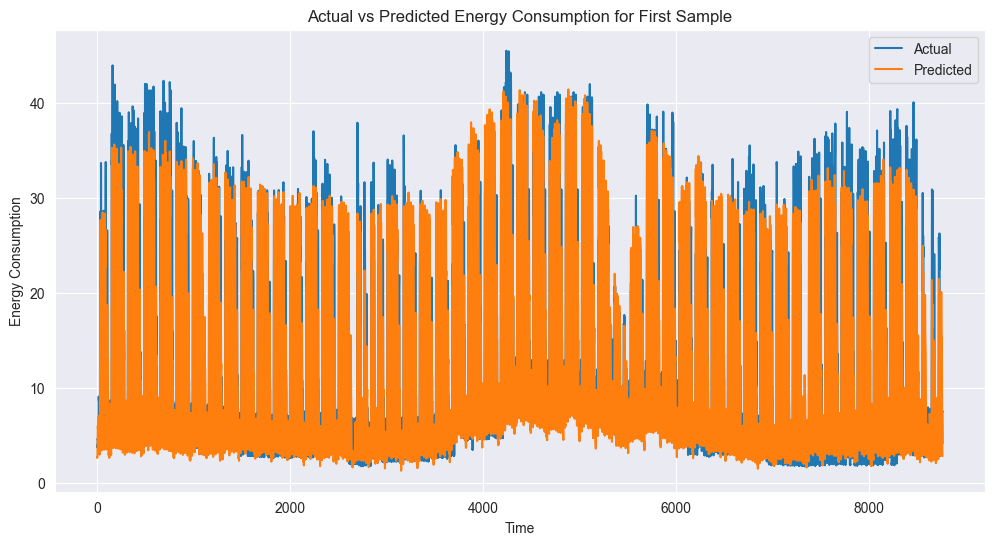

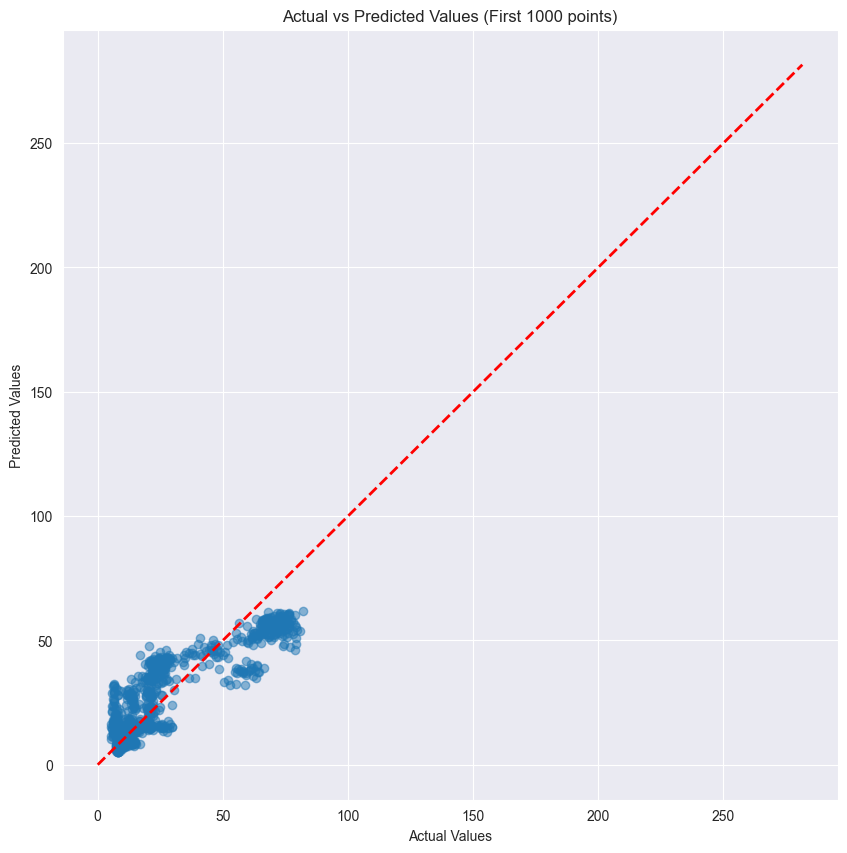

In [11]:
# Plot the first prediction and real curve
plt.figure(figsize=(12, 6))
plt.plot(y_true_2[15], label='Actual')
plt.plot(predictions_2[15], label='Predicted')
plt.title('Actual vs Predicted Energy Consumption for First Sample')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

# Plot a scatter plot of actual vs predicted values for the first 1000 points
plt.figure(figsize=(10, 10))
plt.scatter(y_true_2.flatten()[:1000], predictions_2.flatten()[:1000], alpha=0.5)
plt.plot([y_true_2.min(), y_true_2.max()], [y_true_2.min(), y_true_2.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (First 1000 points)')
plt.show()